# Reflectance - ROI of CCA sample
- Sample spectral signature dataframe - CSV
- Double derivative dataframe - CSV
- Figure of Mean Reflectance spectral signature
- First and double derivative figure

## Path

In [65]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spectral as sp
import scipy.signal as ss

# Figures and plot settings
plt.rcParams['figure.figsize'] = [50, 30]
plt.rcParams['figure.dpi'] = 600
kwargs = {'linestyle':':', 'c':'g', 'lw':3}
kwargs2 = {'linestyle':'-', 'c':'r', 'lw':3}

%matplotlib inline

## Data load

In [66]:
# White Reference - Used in plots

white_hdr = r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Imaging_spectroscopy\Phenotyping_macroalgae\data\NIWA-Antarctic-CCA\Kestrel-SG-Reflectance\NIWA-CCA_WhiteReference_2004-08-06_00-36-15_reflectance_SG.hdr"
white_img = r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Imaging_spectroscopy\Phenotyping_macroalgae\data\NIWA-Antarctic-CCA\Kestrel-SG-Reflectance\NIWA-CCA_WhiteReference_2004-08-06_00-36-15_reflectance_SG.img"

target_open = sp.envi.open(white_hdr, white_img)
target_bands = [float(i) for i in target_open.metadata['wavelength']]
target_data = target_open.load()
target_data = target_data[200:315,75:350,4:239]

#sp.imshow(target_data)

white = np.mean(target_data, axis=(0,1))

In [67]:
# Load files
files_path = Path(r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Imaging_spectroscopy\Phenotyping_macroalgae\data\NIWA-Antarctic-CCA\HSI-ROI-Samples")
files = list(files_path.glob('*.txt'))

## Read files

In [68]:
samples = []
columns = ['Wavelength','Min','Mean-Std','Mean','Mean+Std','Max']

for i, file in enumerate(files):
    samples.append(files[i].stem[7:])

In [69]:
roi_mean = []
roi_pstd = []
roi_nstd = []

for i, file in enumerate(files):
    df = pd.read_csv(files[i], header=7, sep=' ', names=columns, index_col=0, skipinitialspace=True)
    roi_mean.append(df['Mean'])
    roi_nstd.append(df['Mean-Std'])
    roi_pstd.append(df['Mean+Std'])
    
samples_df = pd.concat(roi_mean, axis=1, ignore_index=True)
samples_df.columns = samples

samples_pstd = pd.concat(roi_pstd, axis=1, ignore_index=True)
samples_pstd.columns = samples
samples_nstd = pd.concat(roi_nstd, axis=1, ignore_index=True)
samples_nstd.columns = samples

# Discard noisy bands > 400 nm and < 800 nm
samples_df = samples_df.loc['399':'801',:]
samples_pstd = samples_pstd.loc['399':'801',:]
samples_nstd = samples_nstd.loc['399':'801',:]

# Acquire the wavelengths for plotting (as X axis) right after cropping the dataframe.
wavelengths = samples_df.index

## Sample spectral signature [R] dataframe - to CSV

<AxesSubplot:xlabel='Wavelength'>

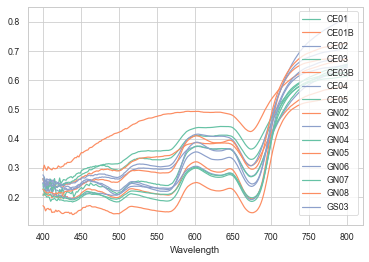

In [70]:
samples_df.plot()
#samples_df.to_csv(r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Imaging_spectroscopy\Phenotyping_macroalgae\results\sample-spectra.csv",
#                 float_format='%f')

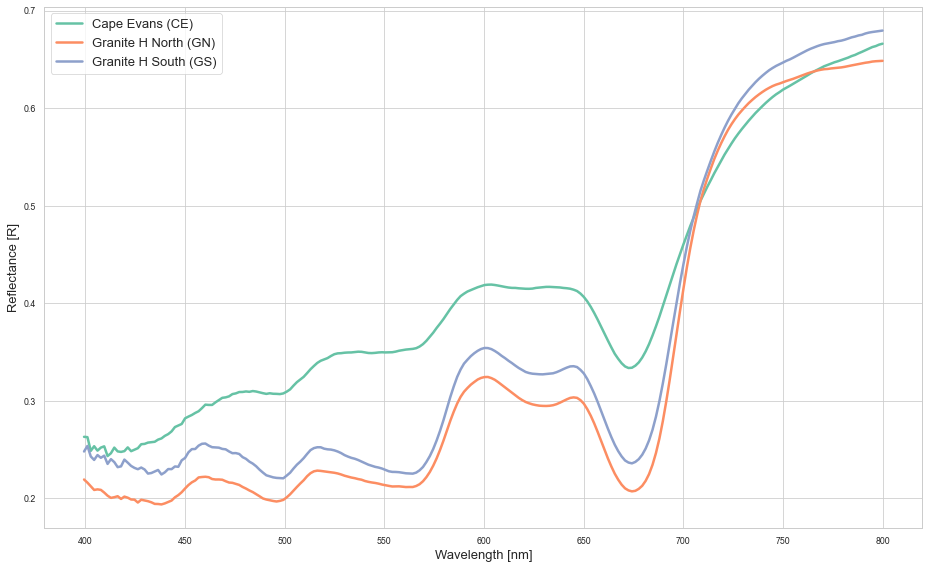

In [63]:
# Where to store plot
out_p = r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Imaging_spectroscopy\Phenotyping_macroalgae\results\Hyperspectral_Imaging"

# Plot
sns.set(rc={'figure.figsize':(13,8)})
sns.set_context("paper")
sns.set_style('whitegrid')
sns.set_palette('Set2',3)

plt.plot(samples_df[['CE01','CE01B','CE02','CE03','CE03B','CE04']].mean(axis=1), label='Cape Evans (CE)', 
         linestyle='-', lw=2.5)
plt.plot(samples_df[['GN02','GN03','GN04','GN05','GN06','GN07','GN08']].mean(axis=1), label='Granite H North (GN)', 
         linestyle='-', lw=2.5)
plt.plot(samples_df[['GS03']].mean(axis=1), label='Granite H South (GS)', 
         linestyle='-', lw=2.5)

plt.xlabel('Wavelength [nm]', fontdict={'fontsize':13})
plt.ylabel('Reflectance [R]', fontdict={'fontsize':13})
plt.legend(prop={'size': 13})
plt.tight_layout()

#plt.savefig(out_p + '\Sites-Reflectance.png', dpi=600)
plt.show()

## Double Derivative [dd] dataframe

In [71]:
derivatives = []

for col in samples_df.columns[:]:
    target = ss.savgol_filter(samples_df[col], 15, 3, deriv = 1)
    derivatives.append(pd.Series(target))

deriv_df = pd.concat(derivatives, axis=1, ignore_index=True)
deriv_df.columns = samples
deriv_df.set_index(wavelengths, inplace=True)

<AxesSubplot:xlabel='Wavelength'>

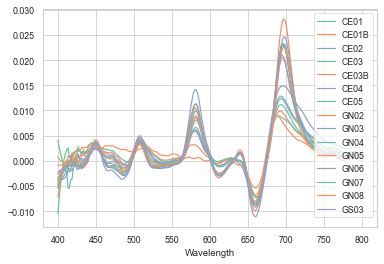

In [75]:
deriv_df.plot()
# deriv_df.to_csv(r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Imaging_spectroscopy\Phenotyping_macroalgae\results\sample-firstderivative.csv",
#                  float_format='%f')

## Inspect bleached samples

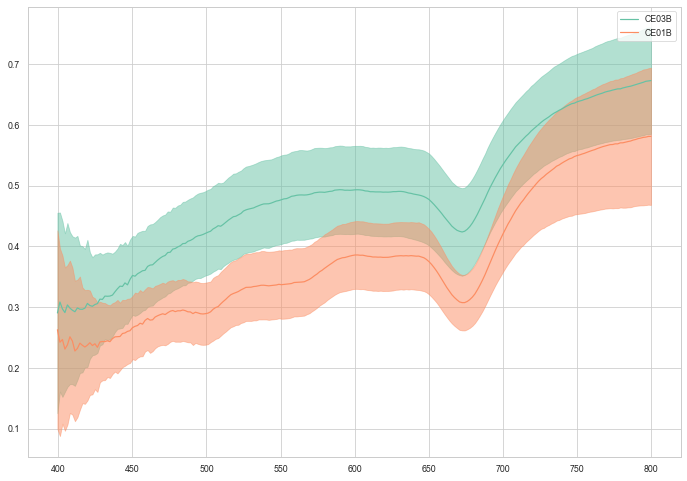

In [10]:
plt.plot(samples_df.CE03B, label='CE03B')
plt.fill_between(wavelengths, samples_pstd.CE03B, samples_nstd.CE03B, 
                 color='C0', alpha=0.5)
plt.plot(samples_df['CE01B'], label='CE01B')
plt.fill_between(wavelengths, samples_pstd.CE01B, samples_nstd.CE01B, 
                 color='C1', alpha=0.5)
#plt.plot(samples_df[['CE01B','CE03B']].mean(axis=1), label='Mean bleached CCA')
plt.legend()
plt.show()

# Plot for publication

In [11]:
# _d as in Drop
samples_df_d = samples_df.drop(labels = ['CE01B','CE03B'], axis=1) # Separate bleached samples

In [12]:
# Where to store figure
out_p = r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Imaging_spectroscopy\Phenotyping_macroalgae\results\Hyperspectral_Imaging"

In [13]:
samples_df['White'] = white

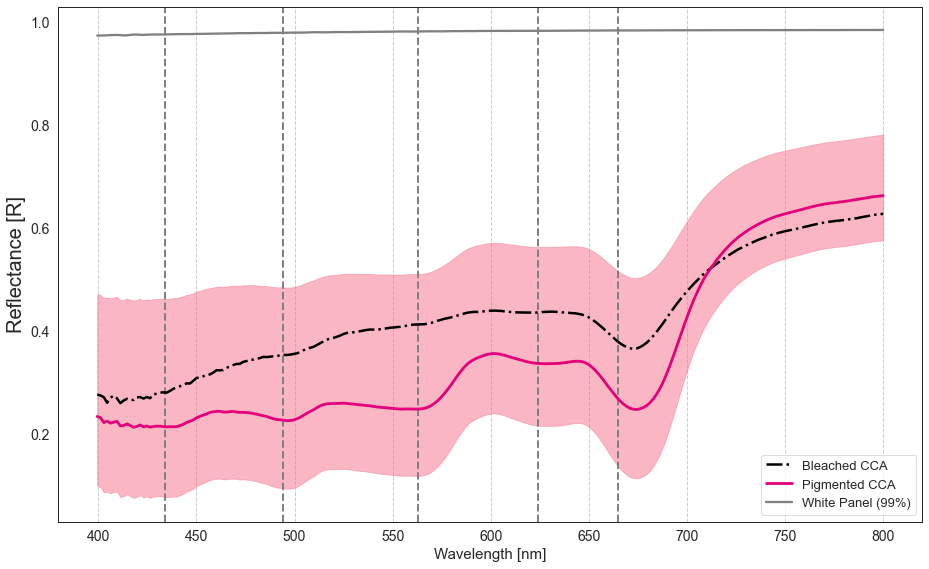

In [58]:
# Reflectance figure
sns.set(rc={'figure.figsize':(13,8)})
sns.set_style('white')
sns.set_context("paper")
sns.set_palette('husl')

# [A] peaks
plt.axvline(434, linestyle='--', lw=2, color='grey')
plt.axvline(494, linestyle='--', lw=2, color='grey')
plt.axvline(563, linestyle='--', lw=2, color='grey')
plt.axvline(624, linestyle='--', lw=2, color='grey')
plt.axvline(665, linestyle='--', lw=2, color='grey')

plt.plot(samples_df[['CE01B','CE03B']].mean(axis=1), label='Bleached CCA', 
         linestyle='-.', lw=2.5, color='black')

plt.plot(samples_df_d.mean(axis=1), label='Pigmented CCA', 
         linestyle='-', lw=2.8, color='#e4007c')
plt.fill_between(wavelengths, 
                 samples_df.mean(axis=1) + samples_df.std(axis=1), 
                 samples_df.mean(axis=1) - samples_df.std(axis=1), 
                 color='C0', alpha=0.5)
plt.plot(samples_df['White'], label='White Panel (99%)', 
         linestyle='-', lw=2.3, color='grey')

plt.legend(prop={'size': 13}, loc=4)
plt.xlabel('Wavelength [nm]', fontdict={'fontsize':15})
plt.ylabel('Reflectance [R]', fontdict={'fontsize':20})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# [dd] peaks
#plt.axvline(438.24, linestyle=':', lw=2, color='teal')
#plt.axvline(495.97, linestyle=':', lw=2, color='teal')
#plt.axvline(569.45, linestyle=':', lw=2, color='teal')
#plt.axvline(624.38, linestyle=':', lw=2, color='teal')
#plt.axvline(679.45, linestyle=':', lw=2, color='teal')

plt.grid(axis='x', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig(out_p + '\Reflectance.png', dpi=600)

plt.show()

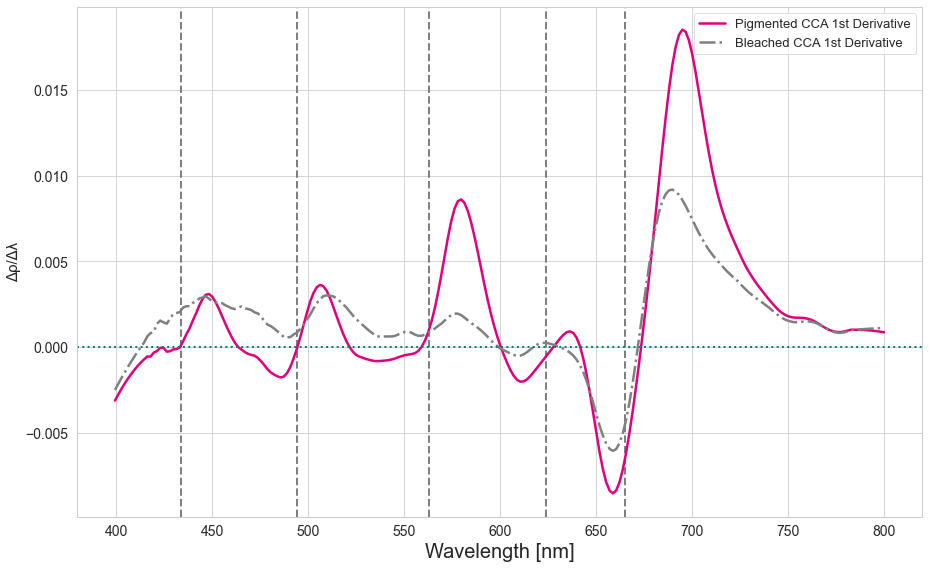

In [31]:
# First derivative figure

sns.set(rc={'figure.figsize':(13,8)})
sns.set_style('whitegrid')
sns.set_context("paper")
sns.set_palette('husl')

# [A] peaks
plt.axvline(434, linestyle='--', lw=2, color='grey')
plt.axvline(494, linestyle='--', lw=2, color='grey')
plt.axvline(563, linestyle='--', lw=2, color='grey')
plt.axvline(624, linestyle='--', lw=2, color='grey')
plt.axvline(665, linestyle='--', lw=2, color='grey')

plt.plot(wavelengths, ss.savgol_filter(samples_df_d.mean(axis=1), 20, 3, deriv=1), label='Pigmented CCA 1st Derivative', linestyle='-', lw=2.5, color='#e4007c')
plt.plot(wavelengths, ss.savgol_filter(samples_df[['CE01B','CE03B']].mean(axis=1), 20, 3, deriv=1), label='Bleached CCA 1st Derivative', linestyle='-.', lw=2.5, color='grey')

plt.axhline(0.0, linestyle=':', lw=2, color='teal')
plt.xlabel('Wavelength [nm]', fontdict={'fontsize':20})
plt.ylabel('Δρ/Δλ', fontdict={'fontsize':15})
plt.legend(prop={'size': 13})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# [dd] peaks
#plt.axvline(434, linestyle=':', lw=2, color='teal')
#plt.axvline(494, linestyle=':', lw=2, color='teal')
#plt.axvline(563, linestyle=':', lw=2, color='teal')
#plt.axvline(624, linestyle=':', lw=2, color='teal')
#plt.axvline(665, linestyle=':', lw=2, color='teal')

plt.tight_layout()
#plt.savefig(out_p + '\Reflectance-1stDerivative.png', dpi=600)
plt.show()

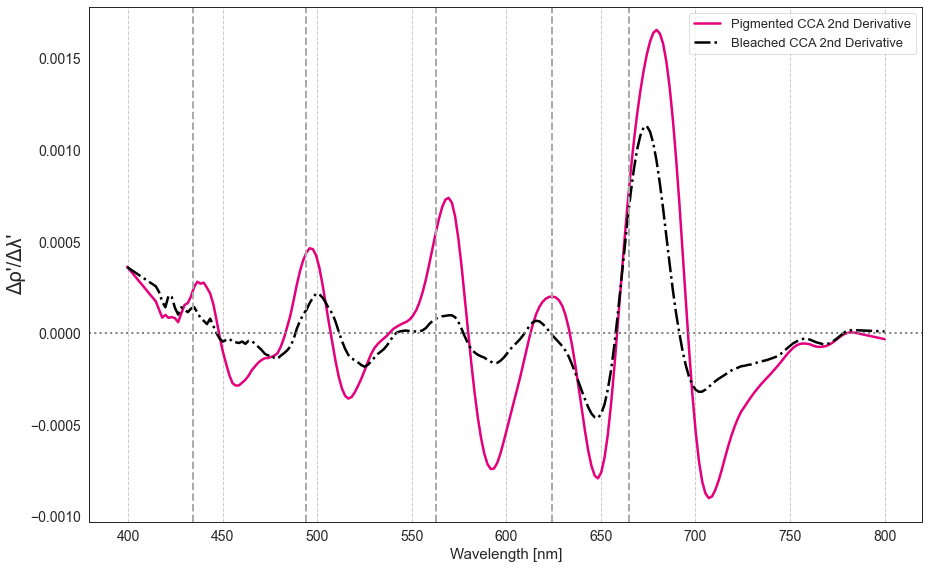

In [59]:
# Second derivative figure
sns.set(rc={'figure.figsize':(13,8)})
sns.set_style('white')
sns.set_context("paper")
sns.set_palette('husl')

plt.plot(
    wavelengths, 
    ss.savgol_filter(samples_df_d.mean(axis=1), 
                     20, 3, deriv=2),
    label='Pigmented CCA 2nd Derivative', linestyle='-',
    lw=2.5, color='#e4007c')

plt.plot(
    wavelengths, 
    ss.savgol_filter(samples_df[['CE01B','CE03B']].mean(axis=1),
                     20, 3, deriv=2), 
    label='Bleached CCA 2nd Derivative', linestyle='-.', 
    lw=2.5, color='black')

plt.axhline(0.0, linestyle=':', lw=2, color='grey')
plt.xlabel('Wavelength [nm]', fontdict={'fontsize':15})
plt.ylabel("Δρ'/Δλ'", fontdict={'fontsize':20})
plt.legend(prop={'size': 13})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# [dd] peaks
#plt.axvline(438.24, linestyle=':', lw=2, color='teal')
#plt.axvline(495.97, linestyle=':', lw=2, color='teal')
#plt.axvline(569.45, linestyle=':', lw=2, color='teal')
#plt.axvline(624.38, linestyle=':', lw=2, color='teal')
#plt.axvline(679.45, linestyle=':', lw=2, color='teal')

# [A] peaks
plt.axvline(434, linestyle='--', lw=2, color='#ababab')
plt.axvline(494, linestyle='--', lw=2, color='#ababab')
plt.axvline(563, linestyle='--', lw=2, color='#ababab')
plt.axvline(624, linestyle='--', lw=2, color='#ababab')
plt.axvline(665, linestyle='--', lw=2, color='#ababab')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', linewidth=1)
plt.savefig(out_p + '\Reflectance-2ndDerivative.png', dpi=600)
plt.show()

## Peak finding

In [16]:
dd = ss.savgol_filter(samples_df_d.mean(axis=1), 20, 3, deriv=2)

In [17]:
zero_crossings = np.where(np.diff(np.sign(dd)))[0]
zero_crossings2 = np.where(np.diff(np.signbit(dd)))[0]

In [18]:
print(zero_crossings)

[ 28  49  63  81 106 125 137 151 173 222 225]


In [19]:
ss.find_peaks(dd, height=0.0001)

(array([ 22,  24,  57, 100, 132, 164], dtype=int64),
 {'peak_heights': array([0.00028011, 0.00027501, 0.00046285, 0.00073811, 0.00019911,
         0.00165479])})

In [23]:
wavelengths[132]

624.38

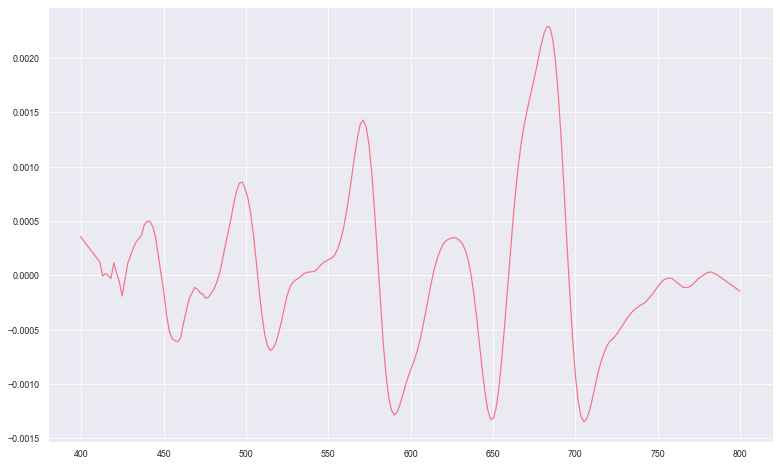

In [73]:
## Derivative peaks
target = deriv_df['GN06']

plt.plot(wavelengths, target)

[571.17, 682.89]


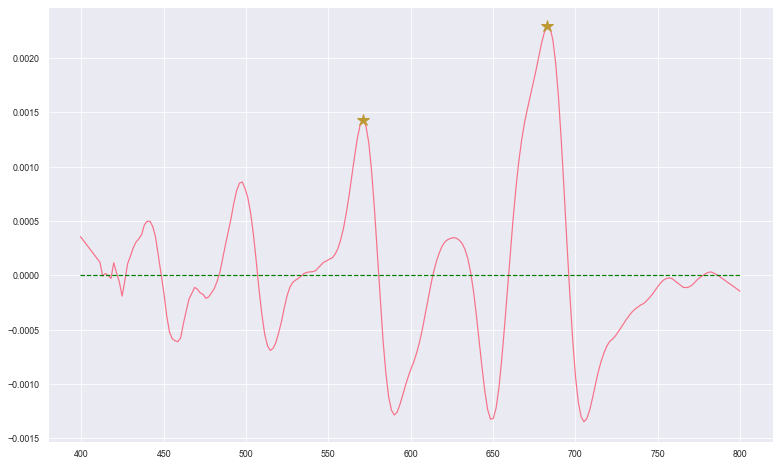

In [77]:
# Positive peaks
peak, _ = ss.find_peaks(target, height=0.001)

peaks = []
for p in peak:
    peaks.append(wavelengths[p])
#print(wavelengths[peak[1]])
print(peaks)

plt.plot(wavelengths, target)
plt.plot(target[peaks], "*", markersize=12)
plt.plot(wavelengths, np.zeros_like(target), "--", color="green")

648.46
[590.03, 648.46, 705.28]


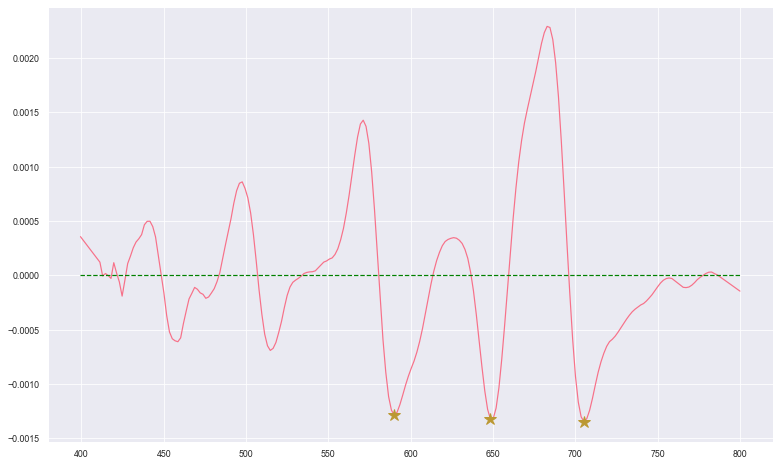

In [78]:
## Negative peaks
peak, _ = ss.find_peaks(target*-1, height=0.001)

peaks = []
for p in peak:
    peaks.append(wavelengths[p])
print(wavelengths[peak[1]])
print(peaks)

plt.plot(wavelengths, target)
plt.plot(target[peaks], "*", markersize=12)
plt.plot(wavelengths, np.zeros_like(target), "--", color="green")
plt.show()

## Plot of all samples

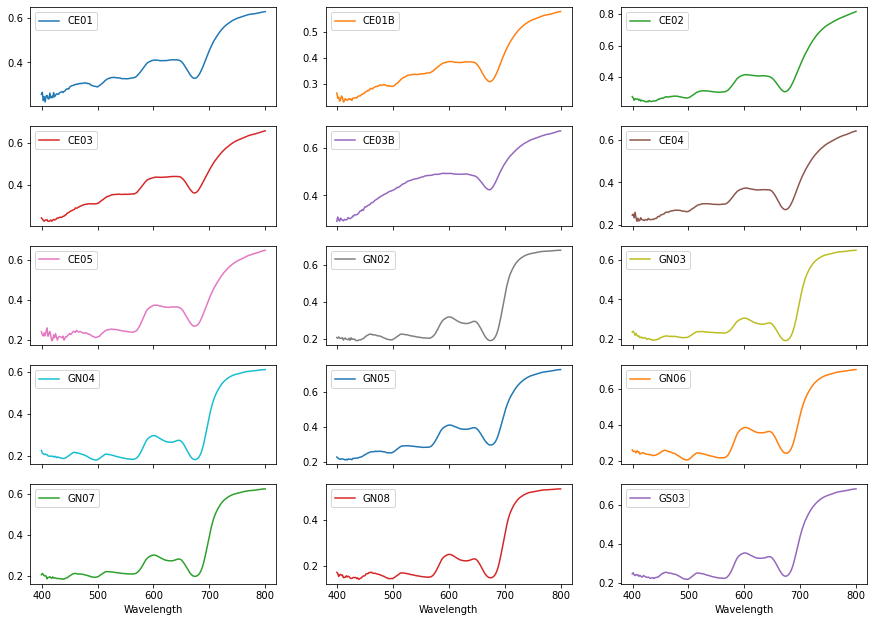

In [11]:
samples_df.plot(subplots=True, layout=(7,3), figsize=(15, 15))
plt.show()

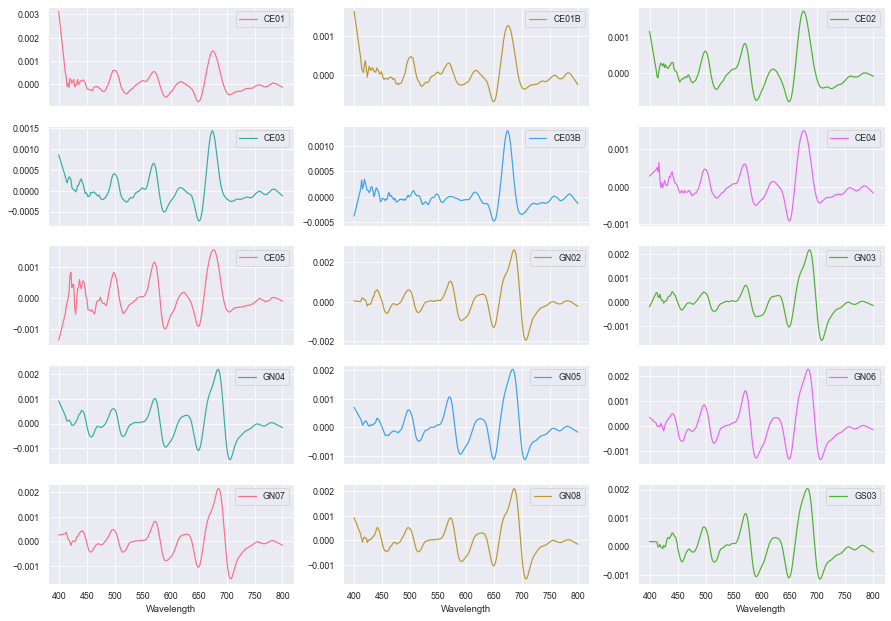

In [79]:
fig = deriv_df.plot(subplots=True, layout=(7,3), figsize=(15, 15))
plt.show()

<AxesSubplot:xlabel='Wavelength', ylabel='Wavelength'>

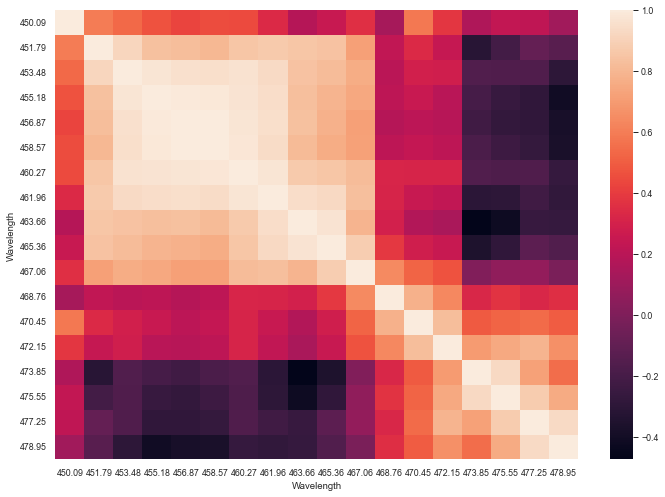

In [67]:
sns.heatmap(deriv_df.loc[450:480].T.corr())